In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import NHP
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
data_paths = np.sort(os.listdir('/storage/data/nhp')).tolist()

In [3]:
nhp = NHP(data_path='/storage/data/nhp/' + data_paths[0])

In [4]:
dt = 0.25

In [5]:
Y = nhp.get_response_matrix(bin_width=dt, region='M1', transform='square_root')
Y = Y[:, np.argwhere(np.sum(Y, axis=0) > 0).ravel()]
Y = Y[:-1, :]

In [23]:
Y -= Y.mean(axis=0, keepdims=True)
Y /= Y.std(axis=0, keepdims=True)

In [6]:
positions = nhp.get_binned_positions(bin_width=dt)

x = positions[:, 0]
#x -= x.mean()
#x /= x.std()

vx = np.ediff1d(x) / dt

y = positions[:, 1]
#y -= y.mean()
#y /= y.std()
vy = np.ediff1d(y) / dt

X = np.vstack((x[:-1], y[:-1], vx, vy)).T

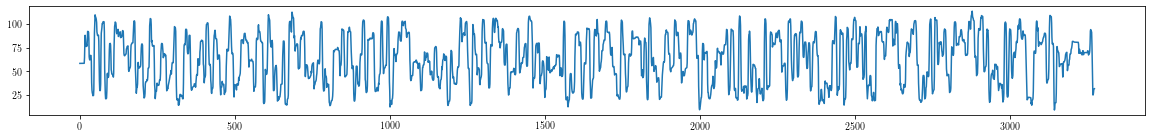

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20, 2))

ax.plot(y)

In [8]:
train_frac = 0.8
n_train = int(Y.shape[0] * train_frac)

In [9]:
X_train = X[:n_train]
X_test = X[n_train:]
Z_train = Y[:n_train]
Z_test = Y[n_train:]

In [10]:
A = np.identity(4)
A[0, 2] = dt
A[1, 3] = dt

In [11]:
ols = LinearRegression(fit_intercept=False)
ols.fit(X_train[:-1, 2:4], X_train[1:, 2:4])
A[2:4, 2:4] = ols.coef_

In [12]:
W = np.zeros(A.shape)
W_full = np.dot((X_train[1:] - np.dot(X_train[:-1], A)).T, X_train[1:] - np.dot(X_train[:-1], A)) / (n_train - 1)
W[2:4, 2:4] = W_full[2:4, 2:4]

In [13]:
ols = LinearRegression(fit_intercept=True)
ols.fit(X_train, Z_train)
C = ols.coef_
d = ols.intercept_
Q = np.dot((Z_train - ols.predict(X_train)).T, Z_train - ols.predict(X_train)) / n_train

In [14]:
ols = LinearRegression(fit_intercept=True)
ols.fit(Z_train, X_train[:, 0])
print(ols.score(Z_test, X_test[:, 0]))
print(np.corrcoef(ols.predict(Z_test), X_test[:, 0])[0, 1])

ols = LinearRegression(fit_intercept=True)
ols.fit(Z_train, X_train[:, 1])
print(ols.score(Z_test, X_test[:, 1]))
print(np.corrcoef(ols.predict(Z_test), X_test[:, 1])[0, 1])

0.3505013017845366
0.6079151982444894
0.44954878282905775
0.6723379079638077


In [14]:
kf = KalmanFilter(
    transition_matrices=A,
    observation_matrices=C,
    observation_offsets=d,
    transition_offsets=np.zeros(4),
    transition_covariance=W,
    observation_covariance=Q
)

In [15]:
means, _ = kf.filter(Z_test)

In [16]:
for idx in range(4):
    print(r2_score(X_test[:, idx], means[:, idx]))
    
print('---')

for idx in range(4):
    print(np.corrcoef(X_test[:, idx], means[:, idx])[0, 1])

0.5605311417796497
0.33704466285108803
0.45506792895613346
0.4836201806120569
---
0.7620731261158984
0.7195149835652265
0.6836344319327741
0.7281713415512375


In [17]:
for idx in range(4):
    print(r2_score(X_test[:, idx], means[:, idx]))
    
print('---')

for idx in range(4):
    print(np.corrcoef(X_test[:, idx], means[:, idx])[0, 1])

0.5605311417796497
0.33704466285108803
0.45506792895613346
0.4836201806120569
---
0.7620731261158984
0.7195149835652265
0.6836344319327741
0.7281713415512375


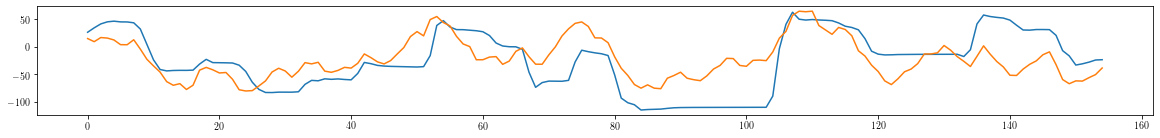

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 2))
plt.plot(X_test[500:, 0])
plt.plot(means[500:, 0])

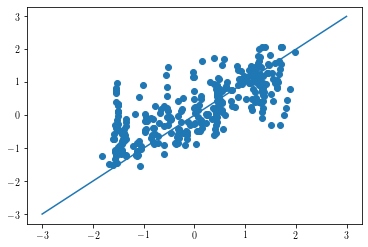

In [22]:
plt.scatter(X_test[:, 0], means[:, 0])
plt.plot([-3, 3], [-3, 3])

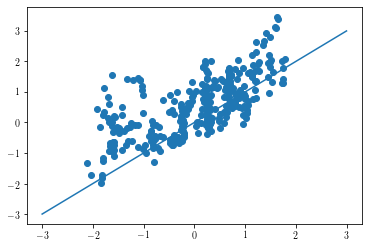

In [20]:
plt.scatter(X_test[:, 1], means[:, 1])
plt.plot([-3, 3], [-3, 3])